<a href="https://colab.research.google.com/github/HaeSeon/nlp-ner/blob/main/bi_LSTM%2BF1_score___.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **양방향 LSTM을 이용한 개체명 인식 + F1-score**

**환경 설치**

In [75]:
!pip install tensorflow
!pip install keras
!pip install tensorflow-gpu


**개체명 인식 데이터에 대한 이해와 전처리**

이번에는 양방향 LSTM과 CRF를 함께 사용하여 앞에서 사용한 데이터 외에 다른 데이터를 사용하여 개체명 인식을 수행해볼것이다.

[데이터 다운로드개체명 인식 데이터에 대한 이해와 전처리

이번에는 양방향 LSTM과 CRF를 함께 사용하여 앞에서 사용한 데이터 외에 다른 데이터를 사용하여 개체명 인식을 수행해볼것이다.

[데이터 다운로드](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)

In [76]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [77]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [78]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


이번 데이터는 하나의 문장을 여러개의 행으로 나누어놓았다. 이는 뒤에서 Pandas의 fillna를 통해 하나로 묶는 작업을 할 것이다.

In [79]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [80]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [81]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [82]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


해당 데이터는 47959개의 문장이 있으며 이 문장들은 35178개의 단어를 가지고 17개 종류의 개체명 태깅을 가지는 것을 알 수 있다. 

In [83]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


BIO 표현방법에서 태깅이 없음을 의미하는 O 가 가장 많은 개수를 차지한다. 

이제부터 데이터를 원하는 형태로 가공해보자.

In [84]:
# ffill은 NULL값 행 바로 앞 행의 값으로 NULL값을 채워준다.
data = data.fillna(method="ffill")

In [85]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [86]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


이렇게 NULL값이 제거되었다. 

In [87]:
# 모든 단어 소문자로 변경
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [88]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍(pair)으로 묶는 작업을 수행

In [89]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [90]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


이러한 샘플이 총 47959개 존재한다. 

이제 훈련을 시키려면 훈련데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야한다. 

In [91]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [92]:
print(sentences[0]) #예측을 위한 X
print(ner_tags[0])  #예측 대상인 Y

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [93]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


위 예시에서 볼 수 있듯 47,959개의 문장 샘플의 길이는 전부 다 다르다. 

전체 데이터의 분포를 확인해보자. 

샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


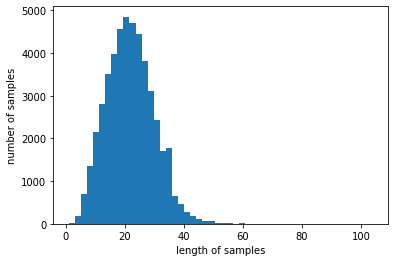

In [94]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

대체적으로 0~40의 길이를 가지며 최대길이는 104인것을 알 수 있다. 

이제 케라스 토크나이저를 통해 정수인코딩을 진행한다. 

In [95]:
# 문장 데이터에 대해서는 src_tokenizer
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
# 개체명 태깅 정보에 대해서는 tar_tokenizer
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [96]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [97]:
# 앞서 src_tokenizer를 만들때 Tokenizer의 인자로 oov_token='OOV'를 선택했으므로 인덱스 1에 'OOV' 할당
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [98]:
# 정수 인코딩
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [99]:
print(X_data[0])  #문장 데이터의 정수 인코딩 결과
print(y_data[0])  #개체명 태깅 데이터에 대해서 정수 인코딩의 결과과

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [100]:
# 모델 훈련 후 결과 확인을 위해 인덱스로부터 단어를 리턴하는 배열 만들어두기
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [101]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [104]:
# 디코딩
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [105]:
max_len = 70
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [106]:
# train : test = 8:2
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [107]:
# 레이블에 대해 one hot 인코딩
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [108]:
# 각 데이터 크기 확인 각 데이터 크기 확인
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)
훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


**F1-Score**

시퀀스 레이블링 모델을 평가 할 때는 큰 의미를 갖지 않는 레이블 정보가 대다수의 레이블을 차지하기 때문에 기존에 사용했던 정확도 평가를 사용하는 것은 적절하지 않다. 
(ex. ner의 O 태깅)

예를들어 모델이 1개의 개체도 맞추지 못하고 전부 'O'로 예상했을 경우를 보자. 


In [109]:
# 예시
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
# 실제값
predicted=['O'] * len(true) #실제값의 길이만큼 전부 'O'로 채워진 리스트 생성. 예측값으로 사용.
print(predicted)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [110]:
hit = 0 # 정답 개수
for t, p in zip(true, predicted):
    if t == p:
        hit +=1 # 정답인 경우에만 +1
accuracy = hit/len(true) # 정답 개수를 총 개수로 나눈다.
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


실제로는 PER, MISC, PER, MISC, PER이라는 총 5개의 개체가 존재하며 이를 하나도 맞추지 못했음에도 불구하고 74.4% 라는 정확도가 나온다. 

이를 해결하기 위해 더 적절한 평가방법을 도입한다. 

정밀도(precision)과 재현률(recall)의 개념을 사용할 것이다. 

정밀도=TP/(TP+FP) : 특정 개체라고 예측한 경우 중에서 실제 특정 개체로 판명되어 예측이 일치한 비율

재현률=TP(TP+FN) : 전체 특정 개체 중에서 실제 특정 개체라고 정답을 맞춘 비율

f1 score=2×(정밀도 × 재현률) / (정밀도 + 재현률) : 정밀도와 재현율의 조화평균

In [111]:
!pip install seqeval

In [112]:
from seqeval.metrics import classification_report
print(classification_report([true], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


이렇게 하면 PER과 MISC 두 특정 개체에 대해서 맞춘것은 하나도 없다는 것을 확인 할 수 있다.

이번에는 어느정도 정답을 맞추었을 때의 f1-score을 계산해보자.

In [113]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']
print(classification_report([true], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



특정 개체로 예측한 경우에 대해서는 모두 제대로 예측을 했으므로 정밀도는 1이 나온다.
하지만 재현율에서는 MISC는 실제는 4개, 2개 맞추었으므로 0.5 PER은 2/3 0.67이 나온 것을 볼 수 있다. 

**F1-score를 측정하는 콜백 클래스**

In [114]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

모델을 학습하는 과정에서 검증 데이터에 대한 F1-score를 출력하기 위해 다음과 같은 클래스를 구현한다. 이를 통해 F1-score를 지속적으로 확인 할 수 있다. 또한 F1-score가 가장 높아질 때 마다 모델을 저장한다. 

In [115]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
      result = []
      for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
          tag = []
          for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
              pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
              tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
          result.append(tag)
      return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs={}):

      # char Embedding을 사용하는 경우
      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      # F1-score가 지금까지 중 가장 높은 경우
      if score > self.value:
        print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        self.model.save('best_model.h5')
        self.value = score
      else:
        print('f1_score did not improve from %f'%(self.value))

**BiLSTM을 이용한 개체명인식기**

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam
from keras.models import load_model

In [117]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [118]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10,  validation_split=0.1, callbacks=[F1score(use_char=False)])

Train on 34530 samples, validate on 3837 samples
Epoch 1/10
34530/34530 [==============================] - 850s 25ms/step - loss: 0.2998 - acc: 0.9249 - val_loss: 0.1560 - val_acc: 0.9539
 - f1: 73.28


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        37
         eve       0.00      0.00      0.00        30
         geo       0.77      0.84      0.80      3087
         gpe       0.88      0.94      0.91      1146
         nat       0.00      0.00      0.00        16
         org       0.57      0.51      0.54      1691
         per       0.58      0.74      0.65      1310
         tim       0.69      0.83      0.75      1672

   micro avg       0.70      0.77      0.73      8989
   macro avg       0.44      0.48      0.46      8989
weighted avg       0.69      0.77      0.73      8989

f1_score improved from 0.000000 to 0.732784, saving model to best_model.h5
Epoch 2/10
34530/34530 [==============================] - 846s 24ms/step - loss: 0.1159 - acc: 0.9649 - val_loss: 0.1292 - val_acc: 0.9604
 - f1: 76.90
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        37
         eve 

In [3]:
bilstm_model = load_model('best_model.h5')

OSError: ignored